### Libraries

In [1]:
# import csv
# import os
import re
import json
import umap

import hdbscan

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from IPython.display import clear_output
from pointgrid import align_points_to_grid

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate

#Lema
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string

#nlp count
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

### Load Data

In [2]:
query = "Query_AI-magazines-mediacloud-2021-24"

FEATHER_FILE = query + ".feather"
df = pd.read_feather('data/' + FEATHER_FILE)


In [3]:
df.shape

(2633, 14)

In [4]:
df['media_name'].value_counts()

media_name
wired.com               929
technologyreview.com    770
theverge.com            468
theatlantic.com         339
medium.com              109
thespectrum.com          18
Name: count, dtype: int64

In [5]:
df = df[df['media_name'] == 'technologyreview.com']

In [6]:
df.shape

(770, 14)

In [7]:
df.sample(3)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,text_downloaded,GPE,IND,ORG
1719,ceb1c82002c3f37c819677eb7abacd441838a32f28bf10...,2024-04-27 22:58:59.719993,en,technologyreview.com,technologyreview.com,2022-11-18,Why Meta’s latest large language model survive...,https://www.technologyreview.com/2022/11/18/10...,2022,Why Meta’s latest large language model survive...,True,[Germany],"[Galactica, Chirag Shah, Galactica, Michael Bl...","[Meta, Meta, Meta, Meta, Big Tech, Meta, Googl..."
860,d03bef91c828f35d188deb63cbd1d20c7dcde61e78c148...,2024-02-18 12:56:45.331800,en,technologyreview.com,technologyreview.com,2023-10-24,This new tool could give artists an edge over AI,https://www.technologyreview.com/2023/10/24/10...,2023,This new tool could give artists an edge over ...,True,"[Midjourney, Beverly, Beverly, Beverly, Beverl...","[Ben Zhao, Zhao, Zhao, Zhao, Realeyes, Realeye...","[AI, DeviantArt, the University of Chicago, Op..."
616,7ab586edce7e3bc16aaa7cbc002509094551fa05fd2ea9...,2024-01-31 03:04:23,en,technologyreview.com,technologyreview.com,2024-01-29,"Dear Taylor Swift, we’re sorry about those exp...",https://www.technologyreview.com/2024/01/29/10...,2024,"Dear Taylor Swift, we’re sorry about those exp...",True,[US],"[Taylor Swift, Taylor]","[Google DeepMind, MIT Technology Review]"


### Clean Data

In [8]:
df.columns

Index(['id', 'indexed_date', 'language', 'media_name', 'media_url',
       'publish_date', 'title', 'url', 'year', 'text', 'text_downloaded',
       'GPE', 'IND', 'ORG'],
      dtype='object')

### Lematization

In [9]:

nlp = spacy.load("en_core_web_lg")

In [10]:
df['text_clean'] = df['title'] + ' ' + df['text'] 

In [11]:
df.text[1]

'What impact will AI have on video game development?\nIt could make working conditions more bearable—or it could just put people out of work.\nThis story is from The Algorithm, our weekly newsletter on AI. To get it in your inbox first, sign up here.\nVideo game development has long been plagued by fear of the “crunch”—essentially, being forced to work overtime on a game to meet a deadline. In the early days of video games, the crunch was often viewed as a rite of passage: In the last days before release, an obsessed group of scrappy developers would work late into the night to perfect their dream game.\nHowever, nowadays the crunch is less likely to be glamorized than to be seen as a form of exploitation that risks causing mental illness and burnout. Part of the issue is that crunch time used to be just before a game launched, but now whole game development periods are “crunchy.” With games getting more expensive, companies are incentivized to make even more short-term profits by sque

In [12]:
words={'ai'}
# Función para limpiar el texto
def clean_text(text):
    # Procesar el texto con spaCy
    doc = nlp(text)
    
    # Lematizar y filtrar stopwords, puntuación y palabras personalizadas
    tokens = [token.lemma_.lower() for token in doc 
              if token.text.lower() not in STOP_WORDS  # Eliminar stopwords
              and token.is_alpha  # Mantener solo caracteres alfabéticos
              and token.text.lower() not in string.punctuation  # Eliminar puntuación
              and token.text.lower() not in words]  # Eliminar palabras específicas
    
    # Unir los tokens limpios en un solo string
    return ' '.join(tokens)

In [13]:
# Aplicar la función de limpieza a la columna 'text'
df['clean_text'] = df['text_clean'].apply(clean_text)

In [14]:
df = df.drop('text_clean', axis=1)

In [15]:
df.head()

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,text_downloaded,GPE,IND,ORG,clean_text
0,fa04f2a7d53cfa67cbac5db21f72131b58dc5d3ef13560...,2024-09-10 15:28:41.289382,en,technologyreview.com,technologyreview.com,2024-09-10,2024 Innovator of the Year: Shawn Shan builds ...,https://www.technologyreview.com/2024/09/10/11...,2024,2024 Innovator of the Year: Shawn Shan builds ...,True,[Midjourney],"[Shawn Shan, Shawn Shan, Shawn Shan, Shan, Sha...","[Glaze, Nightshade, MIT Technology Review, the...",innovator year shawn shan build tool help arti...
1,00dd081954ae78bb816f397a15f0a5f1f08cc32519c4e4...,2024-09-10 11:19:31.849908,en,technologyreview.com,technologyreview.com,2024-09-10,What impact will AI have on video game develop...,https://www.technologyreview.com/2024/09/10/11...,2024,What impact will AI have on video game develop...,True,"[Midjourney, LA, Netherlands]","[Roblox, Roblox, AI, Niall, Josh Kahn]","[a16z, Ubisoft, ChatGPT, ChatGPT, AI, AI, AI, ...",impact video game development impact video gam...
10,dd81b8f5f198bf90f181d1608d05a1955803324090ed07...,2024-09-09 23:21:56.858516,en,technologyreview.com,technologyreview.com,2024-09-09,"To be more useful, robots need to become lazier",https://www.technologyreview.com/2024/09/09/11...,2024,"To be more useful, robots need to become lazie...",True,"[Netherlands, Tech United, UK]","[René van de Molengraft, Van de Molengraft, Va...","[Eindhoven University of Technology, RoboCup, ...",useful robot need lazy useful robot need lazy ...
14,6e756b42d864508050ba087a650179d05ac91be0b4855d...,2024-09-06 18:23:28.427532,en,technologyreview.com,technologyreview.com,2024-09-06,Roblox is launching a generative AI that build...,https://www.technologyreview.com/2024/09/06/11...,2024,Roblox is launching a generative AI that build...,True,"[France, Paris]","[Marcus Holmström, GPT-4, Roblox, Anupam Singh...","[The Gang, Roblox, AI, Roblox, AI, Kent State ...",roblox launch generative build environment sna...
19,3ac10c795421811068dff2c020f48849fad908cb32cb47...,2024-09-05 15:28:38.006311,en,technologyreview.com,technologyreview.com,2024-09-05,Integrating security from code to cloud,https://www.technologyreview.com/2024/09/05/10...,2024,Sponsored\nIntegrating security from code to c...,True,"[withMicrosoft, Jiankui]","[David Harmon, Vlad Korsunsky, Harmon, Flexera...","[AMD, The Human Genome Project, SpaceX, Tesla,...",integrate security code cloud sponsored integr...


In [16]:
# Define helper function
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    Returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample.
    '''
    # Vectoriza el texto
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    
    # Suma de las ocurrencias de cada palabra en todos los documentos
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    
    # Obtiene los índices de las palabras ordenadas por frecuencia
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    
    # Obtiene los valores de las frecuencias
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    # Prepara los vectores de palabras más frecuentes
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i, word_indices[0, i]] = 1

    # Obtiene las palabras correspondientes a los índices más frecuentes
    words = [word for word in count_vectorizer.inverse_transform(word_vectors)[0]]

    return (words, word_values[0,:n_top_words].tolist()[0])


In [17]:
count_vectorizer = CountVectorizer()

In [18]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

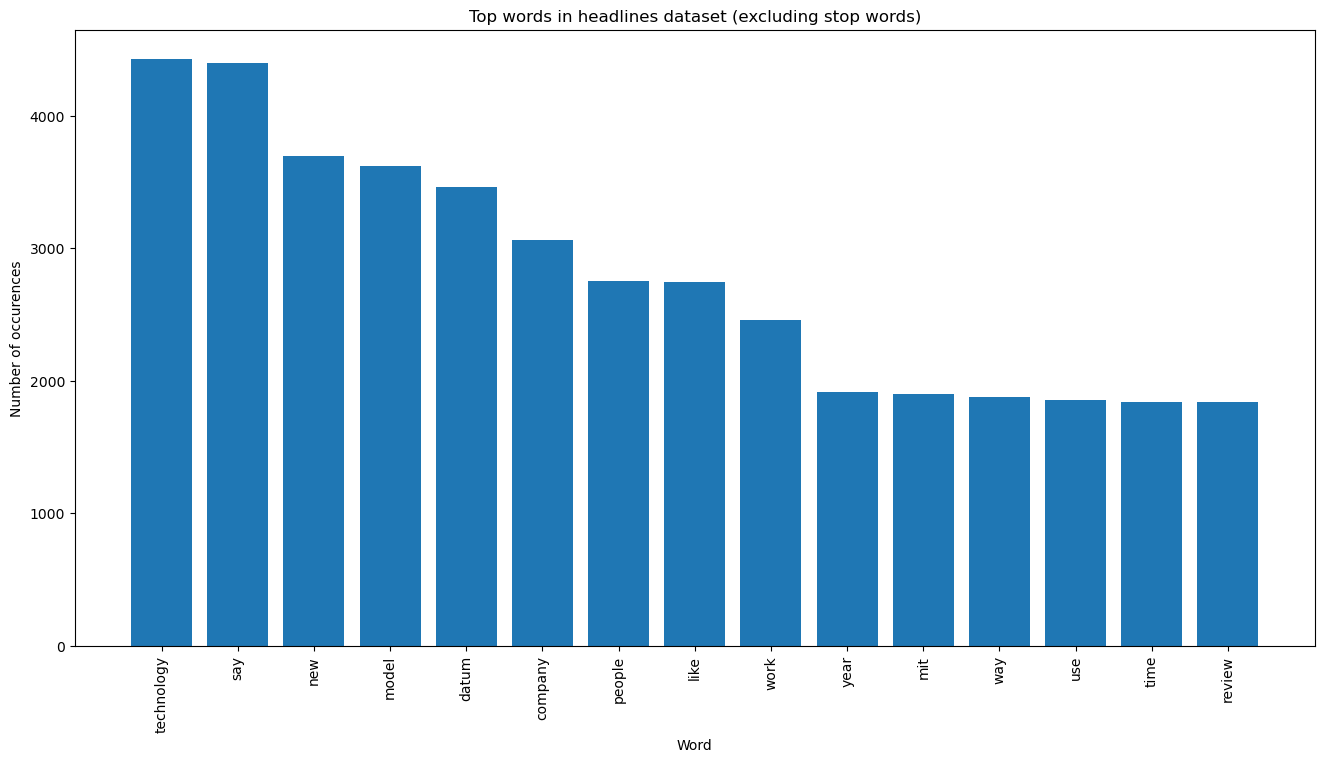

In [28]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=df['clean_text'])

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [29]:
df.head()

,title,url,year,text,entities,temperature,color,x,y,cluster,clean_text
0,2024 Innovator of the Year: Shawn Shan builds ...,https://www.technologyreview.com/2024/09/10/11...,2024,2024 Innovator of the Year: Shawn Shan builds ...,"['Midjourney', 'Karla Ortiz', 'Nightshade', 'W...",2,#0000ff,141.0,522.0,p_16,innovator year shawn shan build tool help arti...
1,What impact will AI have on video game develop...,https://www.technologyreview.com/2024/09/10/11...,2024,What impact will AI have on video game develop...,"['Midjourney', 'Netherlands', 'Clearview AI', ...",2,#0000ff,495.0,334.0,p_19,impact video game development impact video gam...
2,"To be more useful, robots need to become lazier",https://www.technologyreview.com/2024/09/09/11...,2024,"To be more useful, robots need to become lazie...","['Bold Hearts', 'Tech United', 'Tech United’s'...",2,#0000ff,616.0,861.0,p_0,useful robot need lazy useful robot need lazy ...
3,Roblox is launching a generative AI that build...,https://www.technologyreview.com/2024/09/06/11...,2024,Roblox is launching a generative AI that build...,"['Marcus Holmström', 'The Gang', 'AI', 'France...",2,#0000ff,497.0,337.0,p_19,roblox launch generative build environment sna...
4,Integrating security from code to cloud,https://www.technologyreview.com/2024/09/05/10...,2024,Sponsored\nIntegrating security from code to c...,"['TEE', 'Microsoft Security', 'Insights', 'the...",2,#0000ff,632.0,319.0,p_7,integrate security code cloud sponsored integr...


### Save clean text

In [30]:
df.to_csv('Query_AI_text_clean.csv', index=False)

### Analysis

In [14]:
df = pd.read_csv('Query_AI_text_clean.csv')

In [16]:
df.head(3)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,text_downloaded,GPE,IND,ORG,clean_text
0,fa04f2a7d53cfa67cbac5db21f72131b58dc5d3ef13560...,2024-09-10 15:28:41.289382,en,technologyreview.com,technologyreview.com,2024-09-10,2024 Innovator of the Year: Shawn Shan builds ...,https://www.technologyreview.com/2024/09/10/11...,2024,2024 Innovator of the Year: Shawn Shan builds ...,True,['Midjourney'],['Shawn Shan' 'Shawn Shan' 'Shawn Shan' 'Shan'...,['Glaze' 'Nightshade' 'MIT Technology Review' ...,innovator year shawn shan build tool help arti...
1,00dd081954ae78bb816f397a15f0a5f1f08cc32519c4e4...,2024-09-10 11:19:31.849908,en,technologyreview.com,technologyreview.com,2024-09-10,What impact will AI have on video game develop...,https://www.technologyreview.com/2024/09/10/11...,2024,What impact will AI have on video game develop...,True,['Midjourney' 'LA' 'Netherlands'],['Roblox' 'Roblox' 'AI' 'Niall' 'Josh Kahn'],['a16z' 'Ubisoft' 'ChatGPT' 'ChatGPT' 'AI' 'AI...,impact video game development impact video gam...
2,dd81b8f5f198bf90f181d1608d05a1955803324090ed07...,2024-09-09 23:21:56.858516,en,technologyreview.com,technologyreview.com,2024-09-09,"To be more useful, robots need to become lazier",https://www.technologyreview.com/2024/09/09/11...,2024,"To be more useful, robots need to become lazie...",True,['Netherlands' 'Tech United' 'UK'],['René van de Molengraft' 'Van de Molengraft' ...,['Eindhoven University of Technology' 'RoboCup...,useful robot need lazy useful robot need lazy ...


In [17]:
df.shape

(770, 15)

In [7]:
df['clean_text'].isnull().sum()

np.int64(0)

In [6]:
df = df.dropna(subset=['clean_text'])

In [ ]:
#df['clean_text'] = df['clean_text'].fillna('')

### Temperature

In [18]:
min_year = df['year'].min(); max_year = df['year'].max() # Find min and max
mid_year = (max_year + min_year) // 2 # Calculate the middle year
df['temperature'] = df['year'].apply(lambda x: x - mid_year) # Apply the transformation

# Function to interpolate between red (#FF0000) and blue (#0000FF)
def year_to_color(year, min_year, max_year):
    norm = (year - min_year) / (max_year - min_year)  # Normalize between 0 and 1
    return mcolors.to_hex((1-norm, 0, norm))  # Interpolate between red (1, 0, 0) and blue (0, 0, 1)

# Apply the color function based on the year
df['color'] = df['year'].apply(lambda x: year_to_color(x, min_year, max_year))


df.sample(3)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,text_downloaded,GPE,IND,ORG,clean_text,temperature,color
289,0bbbab8fb24db25481b213a6aadb9c90966abf20155490...,2024-02-19 23:08:49.667633,en,technologyreview.com,technologyreview.com,2023-10-03,Why Big Tech’s bet on AI assistants is so risky,https://www.technologyreview.com/2023/10/03/10...,2023,Why Big Tech’s bet on AI assistants is so risk...,True,['Seoul' 'South Korea' 'Hollywood' 'Hollywood'...,['Will Douglas Heaven' 'Messenger' 'Bard' 'Kev...,['Why Big Tech’s' 'OpenAI' 'Meta' 'Google' 'Op...,big tech bet assistant risky big tech bet assi...,1,#5500aa
767,f278f1e0d2f81c579c62345d27e0dd9249128822e840ba...,2024-08-16 20:24:28.007221,en,technologyreview.com,technologyreview.com,2021-01-14,These five AI developments will shape 2021 and...,https://www.technologyreview.com/2021/01/14/10...,2021,Sponsored\nThese five AI developments will sha...,True,['Beijing' 'Xinfadi' 'Changsha' 'Cangzhou' 'Be...,['covid-19'],['Baidu' 'quantum' 'byBaidu' 'Baidu' 'Baidu' '...,development shape sponsored development shape ...,-1,#ff0000
443,2089bec33871eaab670a12cab758d63663138263a519df...,2024-03-02 12:32:52.054961,en,technologyreview.com,technologyreview.com,2023-03-16,Chinese tech giant Baidu releases its answer t...,https://www.technologyreview.com/2023/03/16/10...,2023,Chinese tech giant Baidu just released its ans...,True,['Beijing' 'China' 'Shanghai' 'US' 'China' 'Ch...,['Ernie Bot' 'Robin Li' 'Ernie Bot' 'Ernie Bot...,['Baidu' 'ChatGPT' 'Baidu' 'Baidu' 'AI' 'Baidu...,chinese tech giant baidu release answer chatgp...,1,#5500aa


In [19]:
df.shape

(770, 17)

In [23]:
df = df.dropna(subset=['year'])
df = df.dropna(subset=['clean_text'])

### Term Frequency

In [24]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

vectorizer = CountVectorizer(
    lowercase=False,
    tokenizer=lambda key: key,  # Use if 'entities' is a list of lists
    token_pattern=None  # Disable token_pattern since we are using a custom tokenizer
)

# Convert 'entities' column (which is a list of lists) to a list
entities = df["clean_text"].to_list()

# Vectorize the list of entities
X = vectorizer.fit_transform(entities)

# Apply TF-IDF transformation
tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf.fit(X)
train_data = tfidf.transform(X)

df.head(3)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,text_downloaded,GPE,IND,ORG,clean_text,temperature,color
0,fa04f2a7d53cfa67cbac5db21f72131b58dc5d3ef13560...,2024-09-10 15:28:41.289382,en,technologyreview.com,technologyreview.com,2024-09-10,2024 Innovator of the Year: Shawn Shan builds ...,https://www.technologyreview.com/2024/09/10/11...,2024,2024 Innovator of the Year: Shawn Shan builds ...,True,['Midjourney'],['Shawn Shan' 'Shawn Shan' 'Shawn Shan' 'Shan'...,['Glaze' 'Nightshade' 'MIT Technology Review' ...,innovator year shawn shan build tool help arti...,2,#0000ff
1,00dd081954ae78bb816f397a15f0a5f1f08cc32519c4e4...,2024-09-10 11:19:31.849908,en,technologyreview.com,technologyreview.com,2024-09-10,What impact will AI have on video game develop...,https://www.technologyreview.com/2024/09/10/11...,2024,What impact will AI have on video game develop...,True,['Midjourney' 'LA' 'Netherlands'],['Roblox' 'Roblox' 'AI' 'Niall' 'Josh Kahn'],['a16z' 'Ubisoft' 'ChatGPT' 'ChatGPT' 'AI' 'AI...,impact video game development impact video gam...,2,#0000ff
2,dd81b8f5f198bf90f181d1608d05a1955803324090ed07...,2024-09-09 23:21:56.858516,en,technologyreview.com,technologyreview.com,2024-09-09,"To be more useful, robots need to become lazier",https://www.technologyreview.com/2024/09/09/11...,2024,"To be more useful, robots need to become lazie...",True,['Netherlands' 'Tech United' 'UK'],['René van de Molengraft' 'Van de Molengraft' ...,['Eindhoven University of Technology' 'RoboCup...,useful robot need lazy useful robot need lazy ...,2,#0000ff


## UMAP

c:\Users\UserAlba\anaconda3\envs\visual_studio_code\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\UserAlba\anaconda3\envs\visual_studio_code\Lib\site-packages\pointgrid\pointgrid.py:66: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '800.0000000000002' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[site, ['y', 'x']] = [x,y]
c:\Users\UserAlba\anaconda3\envs\visual_studio_code\Lib\site-packages\pointgrid\pointgrid.py:66: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '554.5454545454547' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.

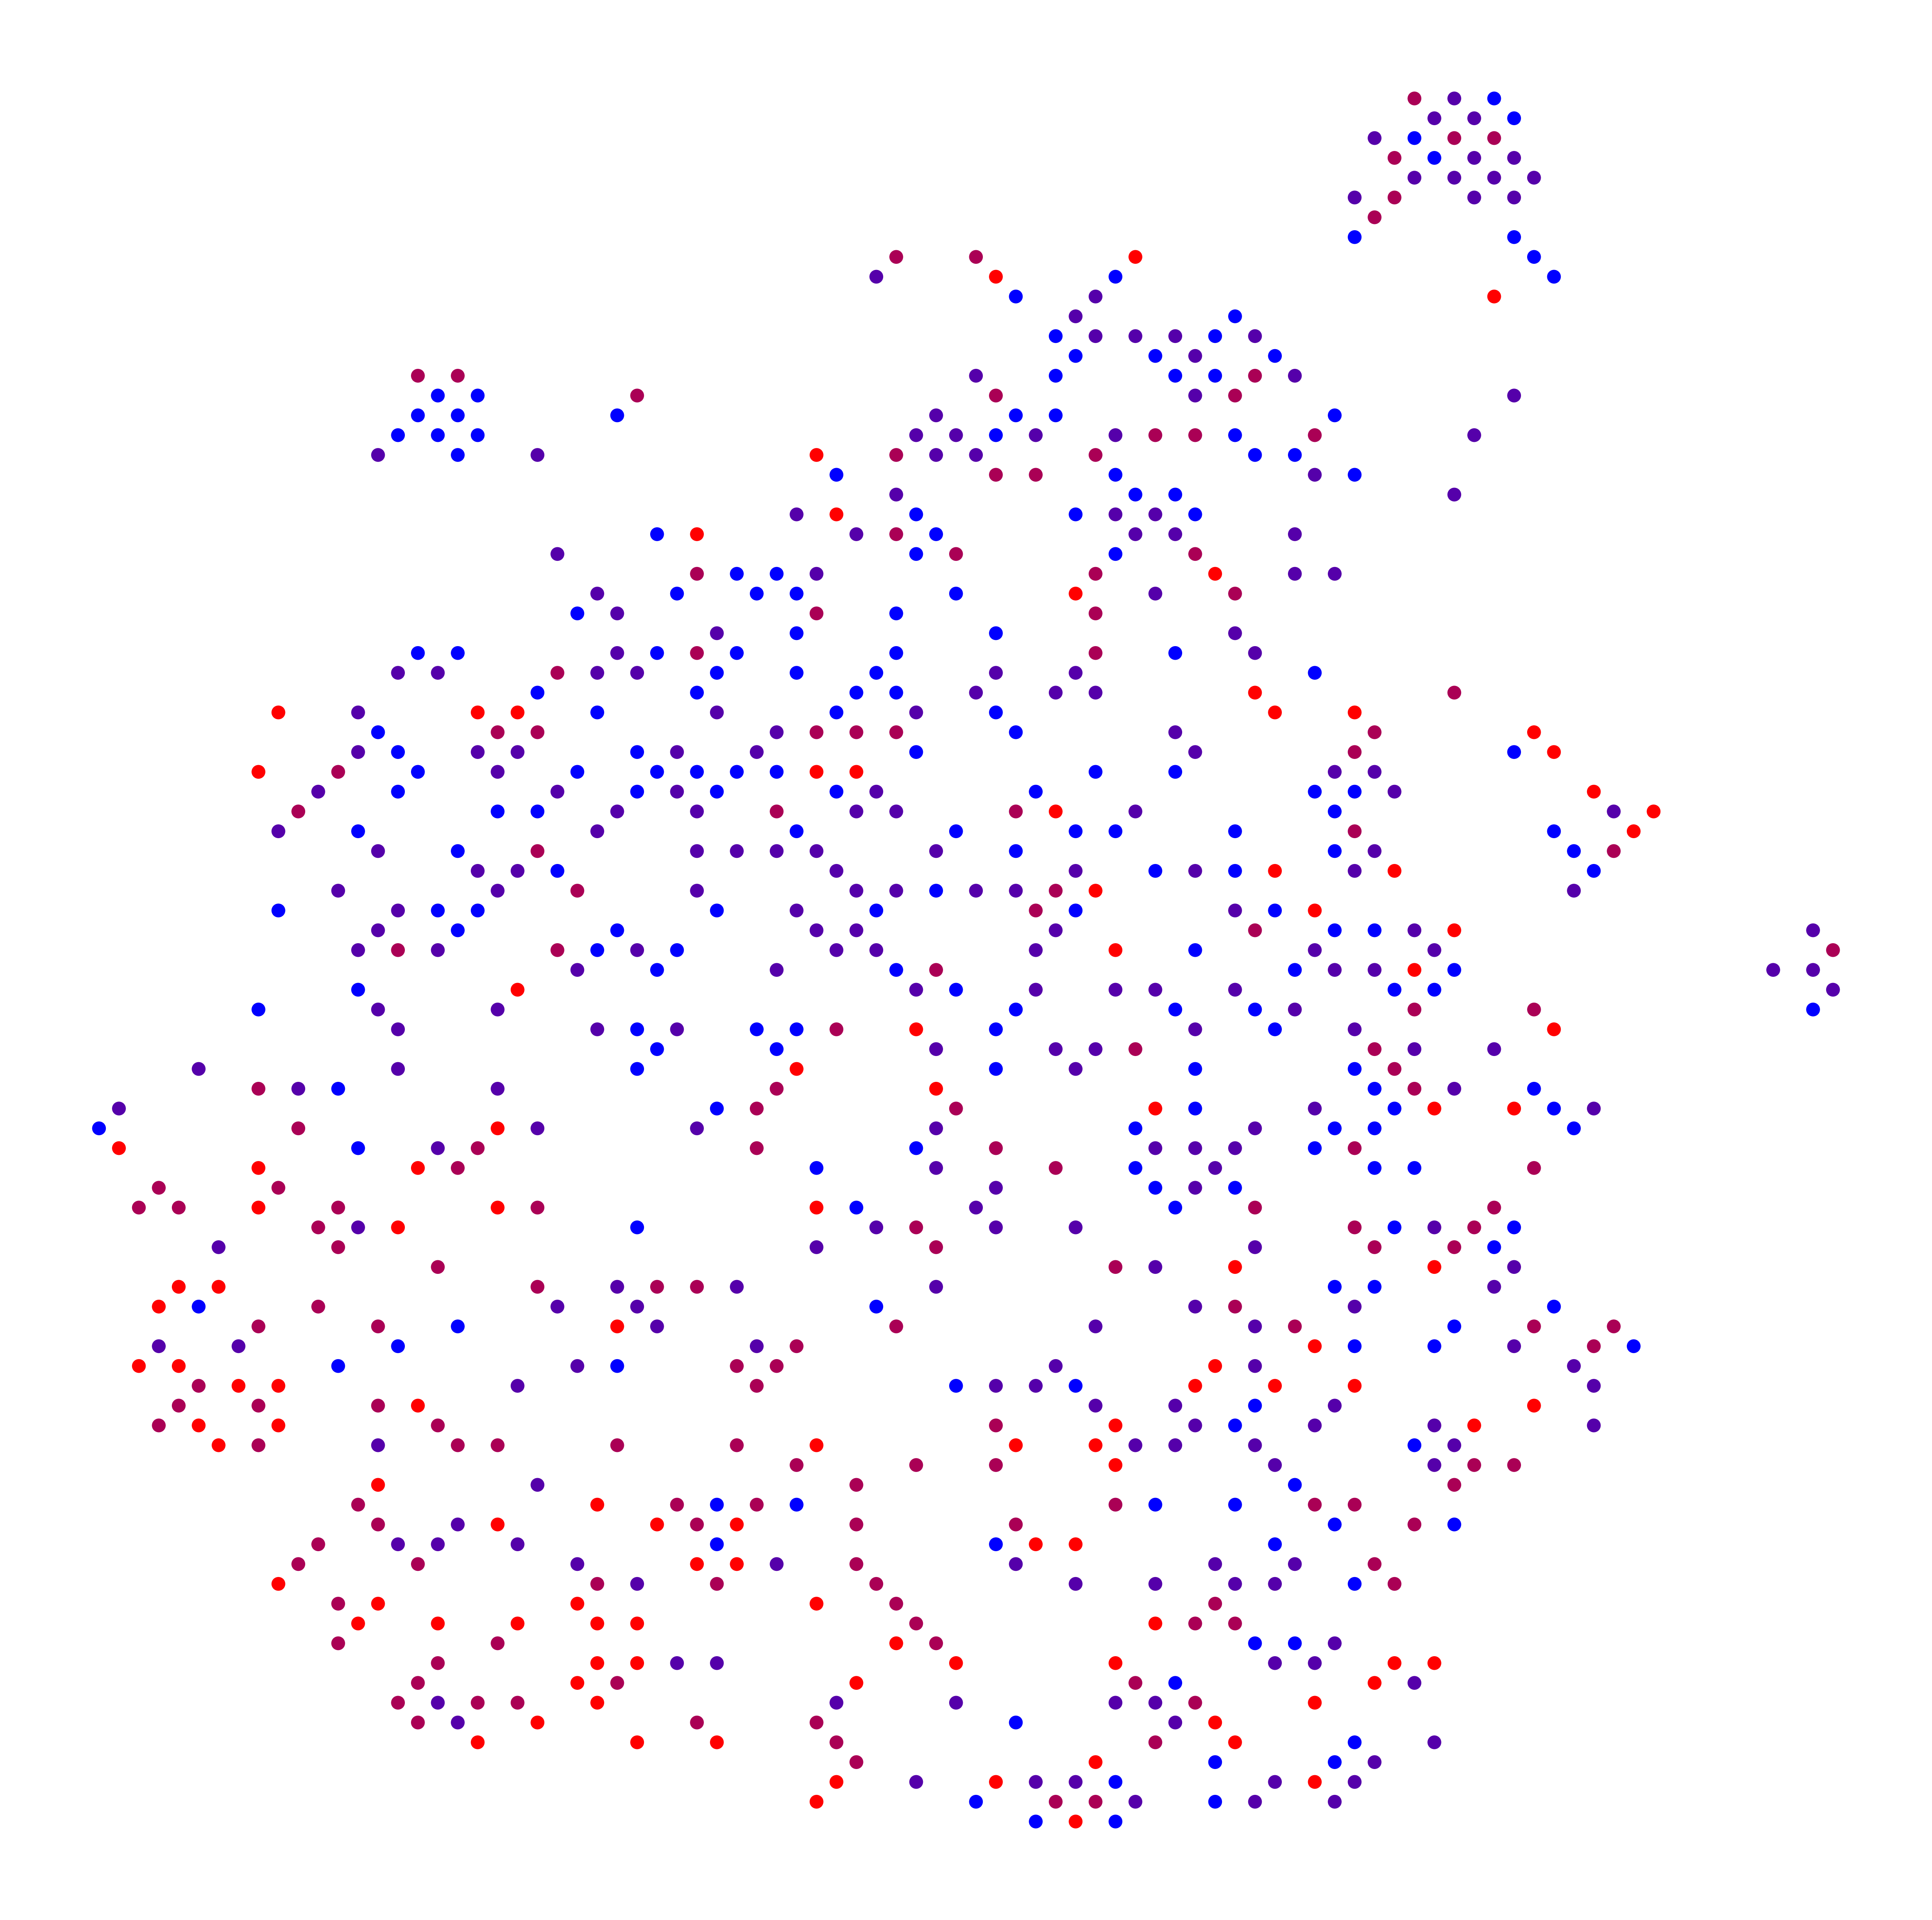

In [25]:
# Fit UMAP reducer without random_state for parallelism
reducer = umap.UMAP(
    random_state=1,
    n_components=2,
    n_neighbors=10,
    min_dist=0.1,
    metric="hellinger"
)

embedding = reducer.fit_transform(train_data) # run UMAP



scaler = MinMaxScaler(feature_range=(100, 900)) # Scale embeddings to a fixed range (100 to 900)
embedding_scaled = scaler.fit_transform(embedding)
embedding_scaled = embedding_scaled.astype(int)

embedding_scaled = align_points_to_grid(embedding_scaled)  # Alignment to a grid

# Assign embeddings (x, y) back to 'entities' DataFrame
index_embedding = 0

for index, row in df.iterrows():
    df.loc[index, "x"] = embedding_scaled[:, 0][index_embedding]
    df.loc[index, "y"] = embedding_scaled[:, 1][index_embedding]
    index_embedding += 1

# Plotting
plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot with size based on 'frequency' and color from 'color'
plt.scatter(
    df["x"].to_list(),
    df["y"].to_list(),
    s=50,
    c=df["color"].to_list(),
)

# Labels
# for i, row in df.iterrows():
#     text = plt.annotate(row["name"], xy=(row["x"], row["y"]), ha="center", va="bottom")
#     text.set_fontsize(3)  # Adjust if too small

# Save the plot
plt.savefig("download.png")


In [28]:
df["x"] = df["x"].astype(int)
df["y"] = df["y"].astype(int)

## Clustering

In [29]:
clusterer = hdbscan.HDBSCAN(
    min_samples=2,            # Aumenta el número de clusters reduciendo los puntos necesarios para un área densa
    min_cluster_size=3,       # Tamaño mínimo del cluster; si lo reduces, obtendrás más clusters
    cluster_selection_epsilon=0.4  # Controla la fusión de clusters cercanos. Reducirlo puede ayudar a obtener más clusters.
)

df["cluster"] = "-1"  # Reset


def cluster_computing(rows, prefix, df):

    embedding = rows[["x", "y"]].to_numpy()
    clusterer.fit(embedding)
    clusters = clusterer.labels_

    # Write cluster number

    for count, (index, row) in enumerate(rows.iterrows()):
        if clusters[count] != -1:
            df.loc[index, "cluster"] = prefix + str(clusters[count])
        else:
            df.loc[index, "cluster"] = str(clusters[count])
    

cluster_computing(
    df.loc[(df["temperature"] > 0)],
    "p_",
    df,
)
cluster_computing(
    df.loc[(df["temperature"] <= 0)],
    "n_",
    df,
)

df.sample(3)

,id,indexed_date,language,media_name,media_url,publish_date,title,url,year,text,text_downloaded,GPE,IND,ORG,clean_text,temperature,color,x,y,cluster
743,268c9b25d254525eefd14ba8556f9a5fe09afec5238d80...,2024-09-03 07:47:30.213506,en,technologyreview.com,technologyreview.com,2021-04-21,This has just become a big week for AI regulation,https://www.technologyreview.com/2021/04/21/10...,2021,This has just become a big week for AI regulat...,True,['America' 'America' 'US'],['Elisa Jillson' 'Ryan Calo' 'Calo' 'Calo' 'Mi...,['AI' 'EU' 'AI' 'FTC' 'EU' 'the US Federal Tra...,big week regulation big week regulation eu unv...,-1,#ff0000,618,354,n_21
355,892964908d7d2ffc5b637f4bb3cba75eb9c775e00dc792...,2024-02-24 17:27:28.233585,en,technologyreview.com,technologyreview.com,2023-07-13,ChatGPT can turn bad writers into better ones,https://www.technologyreview.com/2023/07/13/10...,2023,ChatGPT can turn bad writers into better ones\...,True,[],['Shakked Noy' 'Whitney Zhang' 'Noy' 'Steven S...,['ChatGPT' 'ChatGPT' 'ChatGPT' 'MIT' 'Science'...,chatgpt turn bad writer well one chatgpt turn ...,1,#5500aa,336,636,p_36
206,5b93bc956bc8222c4159578379259786ca089f824ec8c5...,2024-01-19 08:16:54,en,technologyreview.com,technologyreview.com,2024-01-17,Google DeepMind’s new AI system can solve comp...,https://www.technologyreview.com/2024/01/17/10...,2024,Google DeepMind’s new AI system can solve comp...,True,[],['Thang Luong' 'Luong' 'Wen-Tsün Wu' 'Floris v...,['Google DeepMind' 'Google DeepMind' 'AI' 'Alp...,google deepmind new system solve complex geome...,2,#0000ff,263,509,p_47


{'n_20', 'n_23', 'n_1', 'n_5', '-1', 'p_7', 'p_5', 'n_6', 'p_56', 'p_4', 'n_29', 'n_30', 'p_17', 'p_15', 'p_38', 'p_44', 'p_29', 'p_2', 'n_18', 'p_49', 'n_3', 'n_9', 'p_33', 'p_24', 'p_31', 'p_9', 'p_20', 'p_32', 'p_35', 'n_16', 'p_0', 'n_43', 'p_30', 'n_22', 'p_22', 'p_8', 'n_10', 'p_40', 'p_25', 'p_52', 'p_10', 'p_28', 'p_21', 'n_28', 'p_39', 'n_11', 'n_42', 'p_45', 'n_4', 'n_39', 'p_55', 'n_44', 'p_1', 'p_51', 'n_0', 'n_36', 'n_41', 'n_38', 'n_8', 'p_18', 'n_21', 'p_48', 'p_34', 'p_23', 'n_31', 'n_25', 'p_6', 'n_26', 'p_42', 'n_12', 'n_27', 'p_47', 'p_54', 'p_53', 'n_40', 'n_19', 'n_33', 'p_12', 'p_14', 'p_11', 'p_26', 'p_41', 'n_37', 'p_36', 'n_17', 'p_3', 'n_14', 'p_16', 'p_37', 'n_35', 'p_13', 'n_13', 'n_32', 'p_46', 'n_2', 'p_43', 'p_57', 'n_34', 'p_19', 'n_7', 'n_15', 'p_50', 'n_24', 'p_27'}


QhullError: QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1719690705  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 18  Error-roundoff 5.8e-13  _one-merge 2.9e-12
  _near-inside 1.5e-11  Visible-distance 1.2e-12  U-max-coplanar 1.2e-12
  Width-outside 2.3e-12  _wide-facet 7e-12  _maxoutside 3.5e-12

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p2(v3): 6.1e+02 6.7e+02
- p0(v2): 6.2e+02 6.6e+02
- p1(v1): 6e+02 6.8e+02

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 5.8e-13.  The center point, facets and distances
to the center point are as follows:

center point      609      672

facet p0 p1 distance=    0
facet p2 p1 distance=    0
facet p2 p0 distance=    0

These points either have a maximum or minimum x-coordinate, or
they maximize the determinant for k coordinates.  Trial points
are first selected from points that maximize a coordinate.

The min and max coordinates for each dimension are:
  0:       600       618  difference=   18
  1:       663       681  difference=   18

If the input should be full dimensional, you have several options that
may determine an initial simplex:
  - use 'QJ'  to joggle the input and make it full dimensional
  - use 'QbB' to scale the points to the unit cube
  - use 'QR0' to randomly rotate the input for different maximum points
  - use 'Qs'  to search all points for the initial simplex
  - use 'En'  to specify a maximum roundoff error less than 5.8e-13.
  - trace execution with 'T3' to see the determinant for each point.

If the input is lower dimensional:
  - use 'QJ' to joggle the input and make it full dimensional
  - use 'Qbk:0Bk:0' to delete coordinate k from the input.  You should
    pick the coordinate with the least range.  The hull will have the
    correct topology.
  - determine the flat containing the points, rotate the points
    into a coordinate plane, and delete the other coordinates.
  - add one or more points to make the input full dimensional.


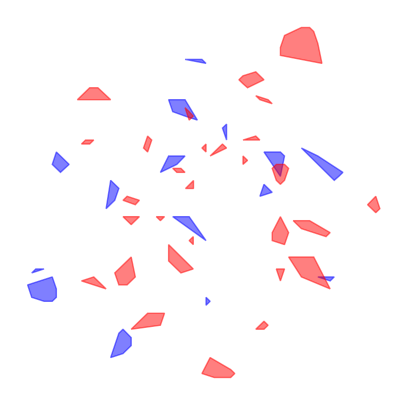

In [30]:
plt.figure(figsize=(5, 5))
plt.axis("off")

clusters = set(df["cluster"].tolist())

print(clusters)

for counter, cluster in enumerate(clusters):

    points = []  # Points
    rows = df.loc[df["cluster"] == cluster]  # Rows

    for index, row in rows.iterrows():
        points.append([row["x"], row["y"]])
    points = np.array(points)

    if len(points) < 3:
        print(len(points))

    hull = ConvexHull(points)  # Hull
    x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0])
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0])

    if cluster[0] == "p":
        plt.fill(x_hull, y_hull, "--", c="#FF0000", alpha=0.5)  # Plot red
    elif cluster[0] == "n":
        plt.fill(x_hull, y_hull, "--", c="#0000FF", alpha=0.5)  # Plot blue


# Save

In [38]:
export = df.copy()

# export = export.drop(columns="entities")


export.to_csv("src/data/entities.csv", index=False)

export.sample(1)

,title,url,year,text,entities,temperature,color,x,y,cluster,clean_text
175,Watch this robot as it learns to stitch up wounds,https://www.technologyreview.com/2024/02/22/10...,2024,Watch this robot as it learns to stitch up wou...,"['Ken Goldberg', 'STAR', 'Super Mario', 'Genie...",2,#0000ff,837.662338,535.818182,p_4,watch robot learn stitch wound watch robot lea...
